# R
# 데이터 정리
1. 누락된 데이터(결측치)
2. 시계열 빈도 변경(업샘플링, 다운샘플링)
3. 데이터 평활
4. 데이터의 계절적 변동 문제 해결
5. 의도치 않은 사전관찰 방지

## 1. 누락된 데이터 다루기
해결법으로는 다음과 같은 방법이 있다.<br>
- 대치법(imputation) : 데이터셋 전체의 관측에 기반해 누락된 데이터를 채워넣는다.
- 보간법(interpolation) :  대치법의 한 형태로 인접한 데이터를 사용하여 누락된 데이터를 추정
- 영향받은 기간 삭제 : 누락된 기간을 사용하지 않음

In [1]:
options( warn = -1 )

In [3]:
# 누락된 데이터에 대치법을 시험하기 위한 데이터셋 준비

# zoo 패키지는 시계열 기능 제공
library(zoo)
require(zoo)
# data.table은 고성능 자료구조
library(data.table)
require(data.table)

In [4]:
library(curl)

Using libcurl 7.64.1 with Schannel


In [5]:
# 1948년 이후 미국의 월간 실업 자료
unemp <- fread("https://raw.githubusercontent.com/PracticalTimeSeriesAnalysis/BookRepo/master/Ch02/data/UNRATE.csv")

In [6]:
head(unemp)

DATE,UNRATE
1948-01-01,3.4
1948-02-01,3.8
1948-03-01,4.0
1948-04-01,3.9
1948-05-01,3.5
1948-06-01,3.6


In [7]:
unemp[, DATE := as.Date(DATE)]
setkey(unemp, DATE)

In [8]:
class(unemp[1,DATE])

[1] "Date"

In [9]:
## 임의로 누락된 데이터로 구성된 데이터셋을 생성
rand.unemp.idx <- sample(1:nrow(unemp), 0.1*nrow(unemp))
rand.unemp <- unemp[-rand.unemp.idx]

## 실업률이 높을 때 누락될 가능성이 더 높은 데이터로 구성된 데이터셋을 생성
high.unemp.idx <- which(unemp$UNRATE > 8)
num.to.select <-0.2* length(high.unemp.idx)

high.unemp.idx <- sample(high.unemp.idx,)   # 무작위 추출, 크기를 지정하지 않았으면 무작위로 뒤섞음
bias.unemp <- unemp[-high.unemp.idx]

In [10]:
all.dates <- seq(from = unemp$DATE[1], to = tail(unemp$DATE,1), by = 'months')

# data.table의 롤링 조인 연산 (설정된 기본키에 따라 조인한다. setkey)
# 타임스탬프가 일치하지 않을때 직전 시점까지의 데이터로 조인해준다.
rand.unemp = rand.unemp[J(all.dates),roll=0]   # key value가 all_dates인 것에 대해 조인 -> 760개의 데이터가 844개로 늘어남
bias.unemp = bias.unemp[J(all.dates),roll=0]
rand.unemp[,rpt := is.na(UNRATE)]

In [11]:
sum(rand.unemp$rpt)

[1] 84

누락된 값들이 포함된 데이터셋이 만들어졌으니 값을 채울 수 있는 방법들을 살펴보도록 한다.

### forward fill
결측값이 나타나기 직전의 값으로 결측값을 채운다.<br>
수식이나 논리가 필요없기 때문에 계산이 간단하고 쉽게 적용할 수 있다.<br>
backward fill도 있으나 사전관찰이기 때문에 특정 상황하에서만 사용한다.

[1] "역삼각형 부분은 forward fill로 채워진 부분"


NULL

NULL

NULL

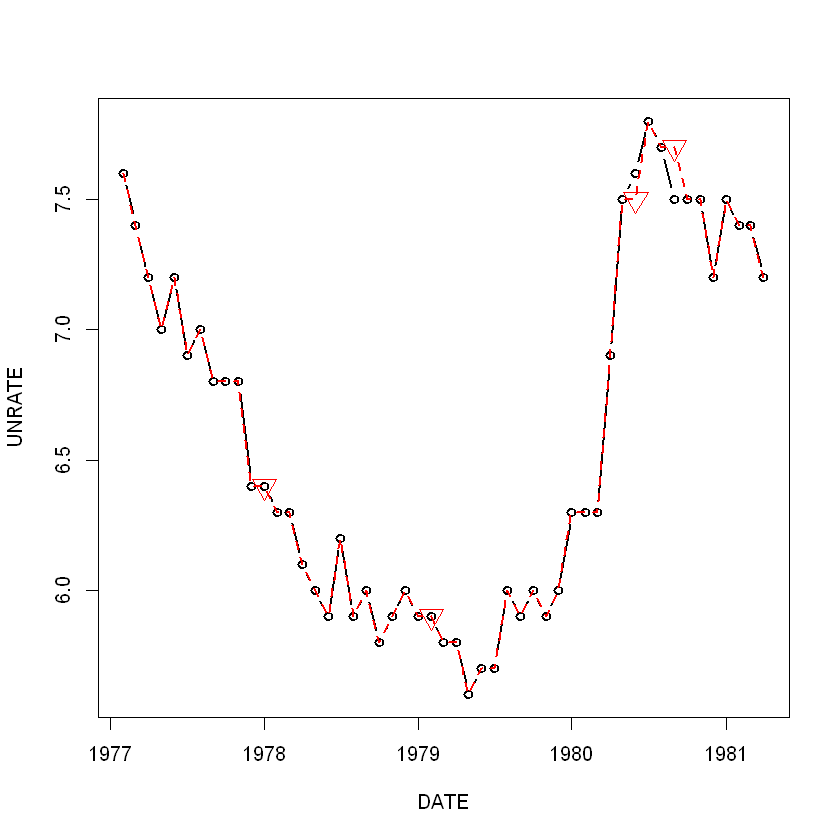

In [12]:
# zoo패키지의 na.locf 함수 사용
rand.unemp[,impute.ff := na.locf(UNRATE, na.rm = FALSE)]
bias.unemp[,impute.ff := na.locf(UNRATE, na.rm = FALSE)]

## 평평한 부분을 보여주는 샘플 그래프
print('역삼각형 부분은 forward fill로 채워진 부분')
unemp[350:400, plot(DATE, UNRATE, col=1, lwd=2, type='b')]
rand.unemp[350:400, lines(DATE, impute.ff, col=2, lwd=2, lty=2)]
rand.unemp[350:400][rpt == TRUE, points(DATE, impute.ff, col=2, pch=6, cex=2)]

### 이동평균(moving average)
전체 평균에 관한 개별 데이터값을 의심할 만한 이유가 있다면 포워드 필보다는 이동평균을 사용해야한다.<br>
포워드 필에 의해 채워진 값은 누락된 값의 실제 관측 값보다 임의의 노이즈를 포함하는데 이동평균은 이러한 노이즈의 일부를 제거할 수 있다.<br>

사전관찰을 방지하기 위해서는 누락이 발생되기 전의 데이터만 사용해야한다.

[1] "녹색은 사전관찰을 배제하기 위해 앞의 세 포인트들로 평균, 붉은 색은 앞 뒤 데이터를 모두 사용해 이동평균한 것"


NULL

NULL

NULL

NULL

NULL

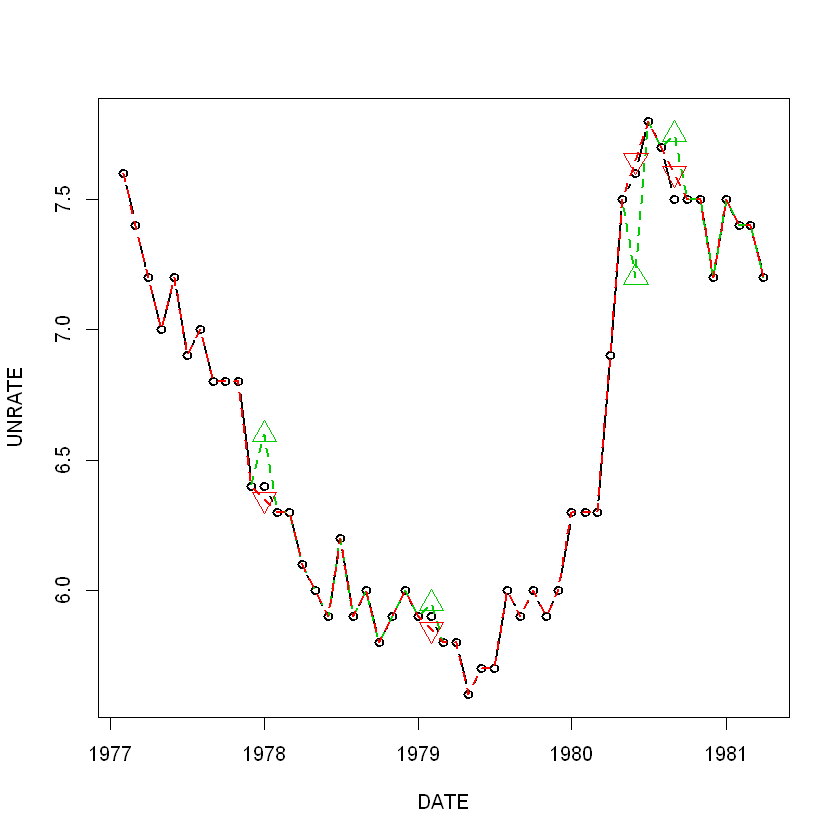

In [13]:
# 마지막 값을 색인하고 이 값을 사용해 누락 여부의 검사 및 대체
rand.unemp[, impute.rm.nolookahead := rollapply(c(NA,NA, UNRATE),3,
                                                  function(x){
                                                      if (!is.na(x[3])) x[3] else mean(x, na.rm=T)
                                                  })]
bias.unemp[, impute.rm.nolookahead := rollapply(c(NA,NA, UNRATE),3,
                                                  function(x){
                                                      if (!is.na(x[3])) x[3] else mean(x, na.rm=T)
                                                  })]

# 사전관찰을 고려하지 않는 경우 앞뒤 데이터를 모두 활용하는 rolling window 적용가능
rand.unemp[,complete.rm := rollapply(c(NA, UNRATE, NA),3,
                                    function(x){
                                        if (!is.na(x[2])) x[2]
                                        else mean(x,na.rm = T)
                                    })]
print('녹색은 사전관찰을 배제하기 위해 앞의 세 포인트들로 평균, 붉은 색은 앞 뒤 데이터를 모두 사용해 이동평균한 것')
unemp[350:400, plot(DATE, UNRATE, col=1, lwd=2, type='b')]
rand.unemp[350:400, lines(DATE, impute.rm.nolookahead, col=3, lwd=2, lty=2)]
rand.unemp[350:400][rpt == TRUE, points(DATE, impute.rm.nolookahead, col=3, pch=2, cex=2)]
rand.unemp[350:400, lines(DATE, complete.rm, col=2, lwd=2, lty=2)]
rand.unemp[350:400][rpt == TRUE, points(DATE, complete.rm, col=2, pch=6, cex=2)]

롤링 평균에 의한 데이터 대치는 데이터셋의 분산 정도를 줄여주기 때문에 모델 지표 계산시 성능을 과대 평가하는 문제에 맞닥드릴 수 있다.

## 보간법
- 선형보간법(linear interpolation) : 누락된 데이터가 주변 데티터에 선형적인 일관성을 갖도록 제한 $\rightarrow$ 시간에 따라 시스템이 동작하는 방법을 이미 알고 있고, 그 지식을 활용할 때 유용(대치에 선험성(prior)을 사용할 수 있음)


[1] "붉은 선은 선형보간, 녹색 선은 다항식 보간"


NULL

NULL

NULL

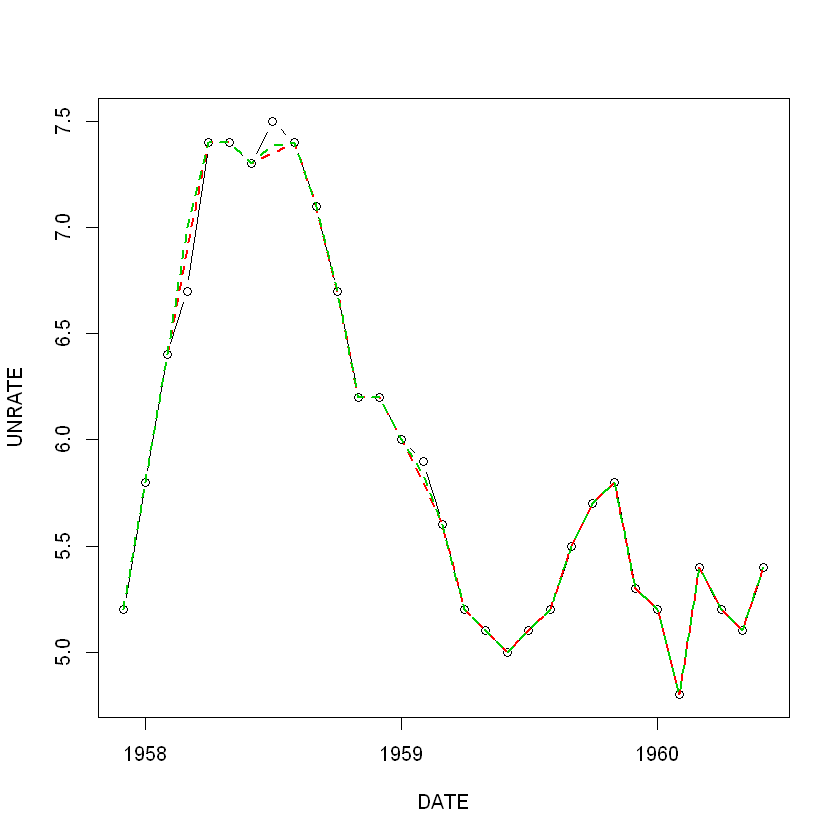

In [14]:
# 과거와 미래 데이터 모두를 사용해 보간법을 적용

## 선형 보간법
rand.unemp[, impute.li := na.approx(UNRATE)]
bias.unemp[, impute.li := na.approx(UNRATE)]

## 다항식 보간법
rand.unemp[, impute.sp := na.spline(UNRATE)]
bias.unemp[, impute.sp := na.spline(UNRATE)]

print('붉은 선은 선형보간, 녹색 선은 다항식 보간')
use.idx = 120:150
unemp[use.idx, plot(DATE,UNRATE, col=1, type='b')]
rand.unemp[use.idx, lines(DATE, impute.li, col=2, lwd=2, lty=2)]
rand.unemp[use.idx, lines(DATE, impute.sp, col=3, lwd=2, lty=2)]

## 비교
평균제곱오차가 높은 비율로 나열

In [15]:
sort(rand.unemp[,lapply(.SD, function(x) mean((x-unemp$UNRATE)^2, na.rm=T)), 
                        .SDcols = c('impute.ff','complete.rm','impute.rm.nolookahead','impute.li','impute.sp')])

impute.li,impute.sp,complete.rm,impute.ff,impute.rm.nolookahead
0.001424105,0.00151109,0.001561019,0.003672986,0.005536137


In [16]:
setequal(rand.unemp[,.SD],rand.unemp)

[1] TRUE

## 업샘플링과 다운샘플링

### 다운샘플링
데이터의 빈도를 줄임<br>
- 원본 데이터의 시간 단위가 실용적이지 않은 경우
    - ex) 너무 잦은 측정
- 계절 주기의 특정 부분에 집중하는 경우
    - 데이터의 전반적인 계절성에 신경쓰기 보다 하나의 특정 계절에만 초점을 맞추는 시계열 데이터
- 더 낮은 빈도의 데이터에 맞추는 경우
    - 평균, 합계, 나중 데이터에 가중치를 주는 가중 평균 등을 사용

In [18]:
# 1월 데이터에 집중
head(unemp[seq.int(from=1, to=nrow(unemp),  by=12)])

DATE,UNRATE
1948-01-01,3.4
1949-01-01,4.3
1950-01-01,6.5
1951-01-01,3.7
1952-01-01,3.2
1953-01-01,2.9


In [21]:
# 년도별 실업률의 평균
head(unemp[,mean(UNRATE), by=format(DATE,'%Y')])

format,V1
1948,3.750000
1949,6.050000
1950,5.208333
1951,3.283333
1952,3.025000
1953,2.925000


### 업샘플링
실제로 측정하는 것은 아니지만 측정된 데이터에서 더 조밀한 시간의 데이터를 얻기 위한 시도 $\rightarrow$더 많은 시간의 레이블이 추가되는 것은 맞지만, 더 많은 정보 자체가 추가되는 것은 아님
- 시계열이 불규칙적인 상황
    - 데이터 사이의 시차보다 더 높은 빈도로 전체 데이터를 변환할 가능성이 높기 때문에 업샘플링의 한 형태로 볼 수 있다.$\rightarrow$롤링 조인 사용
- 입력이 서로 다른 빈도로 샘플링된 상황
    - 서로 다른 빈도를 같은 시간대로 정렬하기 위해 업샘플링이 필요하지만 사전관찰의 위험이 따름

In [43]:
# 시계열이 불규칙적인 상황
all.dates <- seq(from = unemp$DATE[1], to=tail(unemp$DATE,1),by = 'months')
setkey(rand.unemp, DATE)
rand.unemp = rand.unemp[J(all.dates), roll=0]

In [45]:
# 입력이 서로 다른 빈도로 샘플링된 상황
all.dates <- seq(from = unemp$DATE[1], to=tail(unemp$DATE,1),by = 'days')
daily.unemployment = unemp[J(all.dates), roll=31]
head(daily.unemployment)

DATE,UNRATE
1948-01-01,3.4
1948-01-02,3.4
1948-01-03,3.4
1948-01-04,3.4
1948-01-05,3.4
1948-01-06,3.4


## 데이터 평활
데이터 평활의 이유 : 측정의 오류, 높게 튀는 측정치(정확한 것일지라도 근복적인 공정을 반영한 결과가 아닐 가능성 있음) 두 개를 모두 제거하기 위해 이동평균을 사용해 볼 수 있다.

### 지수평활
최근에 측정된 데이터에 더 큰 가중치를 주고 싶은 경우<br>
시간 $t$에서 평활된 값 : $S_t = d \times S_{t-1} + (1-d) \times x_t$<br>
시간 $t-1$에서 평활된 값 : $S_{t-1} = d \times S_{t-2} + (1-d) \times x_{t-1}$

$\Rightarrow S_t = d\times(d\times S_{t-2} + (1-d)\times x_{t-1})+(1-d)\times x_t$<br>
$\Rightarrow d^3 \times x_{t-3} + d^2 \times x_{t-2} + d \times x_{t-1}$과 같은 연쇄적 형태

$\Rightarrow$ 파이썬 코드로 소개

# 계절성 데이터
일련의 동작이 정해진 기간 동안 반복되는 시계열<br>
순환성 시계열 역시 반복적인 동작을 보이기는 하지만, 기간이 가변적이라는 점이 다름(ex)주식시장의 호황과 불황 주기)

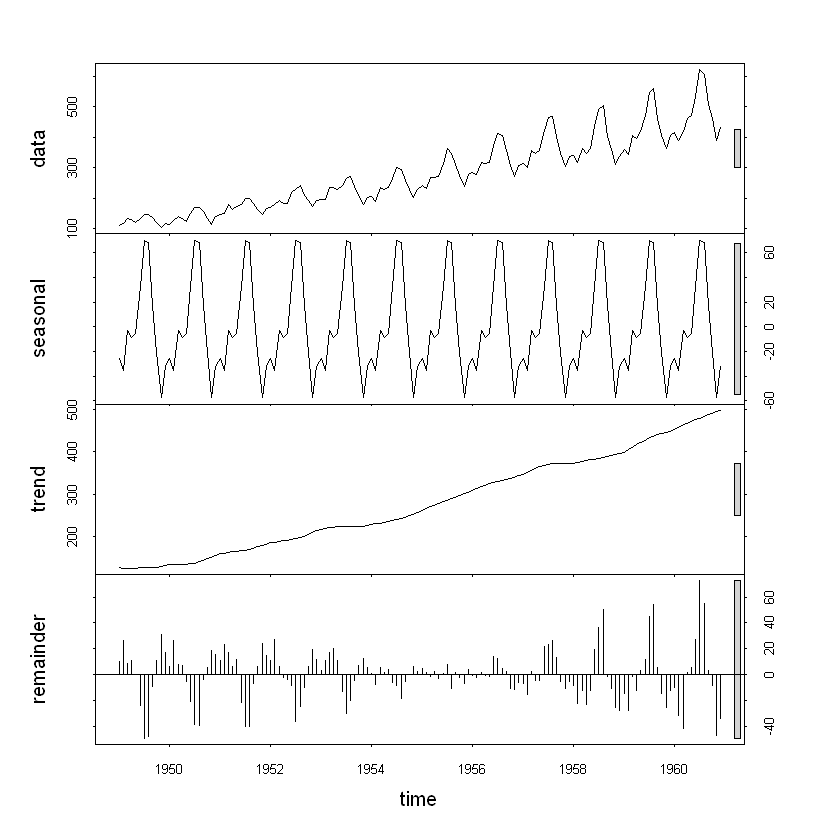

In [46]:
plot(stl(AirPassengers,'periodic'))